# INTERPRETING LAPLACE TRANSFORMS IN CHEMICAL NETWORKS

This notebook explores the relationship between network structure and the networks Transfer Function.

We use the following notation:
* $s$: Laplace transform variable
* $G(s)$: Transfer function
* $S_n$: $n$-th chemical species
* $x_n (t), ~ x_n$: Concentration of $S_n$ at time $t$
* $\dot{x}_n (t), ~ \dot{x}_n$: First derivative of $x(t)$
* $X_n(s)$: Laplace Transform of the concentration of $S_n$

Reactions are described by arrows. The annotation above the arrow is the reaction rate. (Previously, we had assumed mass action kinetics and so just used the kinetic constants.) For example, $S_1$ is converted to $S_2$ at a rate $kx_1$ (where $x_1$ is the concentration of $S_1$ at time $t$) is denoted by $S_1 \xrightarrow{kx_1} S_2$.

The first part introduces 3 network structures and their Transfer Functions.
The second part is an exercise in exploring the conditions in which one network structure can approximate another network structure.

# Preliminaries

In [10]:
!pip install -q controlSBML
!pip install -q control
import numpy as np
import control
import controlSBML as ctl
import matplotlib.pyplot as plt
import sympy
import tellurium as te
from typing import Tuple, List

In [11]:
TIMES = np.linspace(0, 20, 200)

# Models

The reference models are simple reaction networks that have particular Laplace Transforms. We use these to approximate more complex reaction networks.

## One Step Sequential

### Reaction Network

Consider the one step sequential pathway with mass action kinetics
\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & \emptyset \\
\end{eqnarray}

We want to control $s_2$ by manipulating $S_1$.
We will manipulate $s_1$ by controlling its concentration in solution.

The transfer function is $G_1(s) = \frac{X_2 (s)}{X_1 (s)} = \frac{k_1}{s + k_2}$

### Find the kinetic constants for the network whose transfer function is $G_1(s)$

By inspection
1. Change the transfer function so that $s$ has a coefficient of 1.
2. $k_1$ is the numerator.
3. $k_2$ is the denominator
4. Write the model.

A more generalizable approach
1. Let $p$ be the pole of the transfer function and $d$ be its dcgain.
2. $k_2 = -p$
3. $k_1 = - d p$

We can solve this system because there are two equations (1 pole, dcgain) and two unknowns.

### Evaluation

General expression

$$\frac{m}{s - p}$$,

where $m$ is the multiplier and $p$ is the pole.

In [32]:
 def evaluateOneSequential(multiplier:float, pole:float, times=TIMES,
        is_plot:bool=True)->Tuple[control.TransferFunction, np.ndarray]:
    """
    Construct the transfer function, and simulate it.
    """
    tf = control.TransferFunction([multiplier], [1, -pole])
    _, yv = control.step_response(tf, T=times)
    plt.plot(times, yv)
    if not is_plot:
        plt.close()
    return tf, yv

# TESTS
results = evaluateOneSequential(2, -1, is_plot=False)
assert(isinstance(results[0], control.TransferFunction))
assert(len(results[1]) == len(TIMES))
print("OK!")

OK!


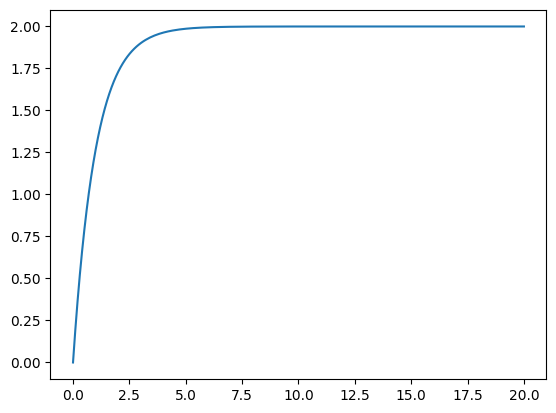

In [18]:
tf, yv = evaluateOneSequential(2, -1)

In [19]:
tf

TransferFunction(array([2]), array([1, 1]))

## Two Step Sequential

### Reaction network

\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & S_3 \\
S_3 & \xrightarrow{k_3 x_3} & \emptyset \\
\end{eqnarray}

Find the transfer function
\begin{eqnarray}
G_2(s)
 & = & \frac{k_1 k_2 }{(s + k_2)(s + k_3)} \\
 & = & \frac{k_1 k_2 }{s^2 + (k_2 + k_3)s + k_2 k_3} \\
 & = & \frac{k_1 k_2 }{s^2 + b s + c} \\
 & = & \frac{m }{s^2 + b s + c} \\
\end{eqnarray}

Clearly, the two poles are $p_1 = -k_2$, $p_2 = -k_3$.
So
* $k_2 = -p_1$
* $k_3 = - p_2$
* $k_1 = dk_3$

### Find the kinetic constants for the network whose transfer function is $G_2(s)$

Let $G_2 (s)$ has dcgain $d$ and poles $p_1, p_2$.

\begin{eqnarray}
d & = & \frac{k_1 k_2}{k_2 k_3} \\
& = & \frac{k_1}{k_2} \\
\end{eqnarray}

\begin{eqnarray}
b & = & - p_1 - p_2 \\
c & = & (-p_1)(- p_2) \\
\end{eqnarray}

Solving, we have
\begin{eqnarray}
c & = & (b + p_2)(- p_2) \\
p_2^2 + b p_2 + c & = & 0 \\
p_2 & = & \frac{1}{2} \left( -b \pm \sqrt{b^2 - 4c} \right) \\
p_1 & = & -b - p_2
\end{eqnarray}

**Question**
1. We know that this systems should have real poles $-k_2, -k_3$. This means the $b^2 \geq 4c$. Can we prove this?

\begin{eqnarray}
b^2 & = & (k_2 + k_3)^2 \\
4c & = & 4 k_2 k_3 \\
\end{eqnarray}

From this, we infer the following:
\begin{eqnarray}
b^2 - 4c & = & k_2^2 + 2k_2 k_3 + k_3^2 - 4 k_2 k_3 \\
& = & k_2^2 - 2 k_2 k_3 + k_3^2 \\
& = & (k_2 - k_3)^2 \\
& \geq & 0 \\
\end{eqnarray}

### Evaluation

General expression

$$\frac{m}{(s - p_1)(s - p_2)}$$,

where $m$ is the multiplier and $p$ is the pole.

OK!


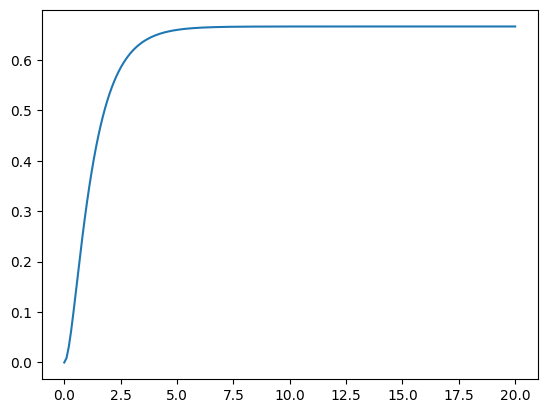

In [22]:
# evaluateTwoStep
def evaluateTwoSequential(multiplier:float, pole1:float, pole2:float,
                          times=TIMES,
        is_plot:bool=True)->Tuple[control.TransferFunction, np.ndarray]:
    """
    Construct the transfer function, and simulate it.
    """
    tf = control.TransferFunction([multiplier], [1, -pole1-pole2, pole1*pole2])
    _, yv = control.step_response(tf, T=times)
    plt.plot(times, yv)
    if not is_plot:
        plt.close()
    return tf, yv

# TESTS
results = evaluateTwoSequential(2, -1, -3, is_plot=False)
assert(isinstance(results[0], control.TransferFunction))
assert(len(results[1]) == len(TIMES))
print("OK!")

## Branching

### Reaction Network

Consider the following model:
\begin{eqnarray}
S_1 & \xrightarrow{k_2 x_1} & S_2 \\
S_1 & \xrightarrow{k_3 x_1} & S_3 \\
S_2 & \xrightarrow{k^d_2 x_2} & \emptyset \\
S_3 & \xrightarrow{k^d_3 x_3} & \emptyset \\
\end{eqnarray}

### Transfer function

Find the transfer function $G_3(s) = \frac{X_3(s) + X_2 (s)}{X_1(s)}$.

Differential equations.
\begin{eqnarray}
\dot{x}_1 = -(k_2 + k_3) x_1 \\
\dot{x}_2 = k_2 x_1 - k^d_2 x_2 \\
\dot{x}_3 = k_3 x_1 - k^d_3 x_3 \\
\end{eqnarray}

Laplace transforms.
\begin{eqnarray}
s X_1(s) = -(k_2 + k_3) X_1 (s) \\
s X_2(s) = k_2 X_1 (s) - k^d_2 X_2 (s) \\
s X_3 (s) = k_3 X_1 (s) - k^d_3 X_3 (s) \\
\end{eqnarray}

Solve for the Transfer Function
\begin{eqnarray}
X_2(s) = \frac{k_2 X_1 (s)}{s + k^d_2} \\
X_3(s) = \frac{k_3 X_1 (s)}{s + k^d_3} \\
X_2(s) + X_3 (s) & = & X_1 (s) \left( \frac{k_2}{s + k^d_2} +  \frac{k_3}{s + k^d_3} \right) \\
& = & \frac{k_2 (s + k^d_3) + k_3 (s + k^d_2)}{(s + k^d_2)(s + k^d_3)} \\
& = & \frac{(k_2 + k_3) s + k_2 k^d_3 + k_3 k^d_2}{(s + k^d_2)(s + k^d_3)} \\
& = & (k_2 + k_3) \frac{ s + \frac{k_2 k^d_3 + k_3 k^d_2}{k_2 + k_3}}{(s + k^d_2)(s + k^d_3)} \\
& = & (k_2 + k_3) \frac{ s + \frac{k_2 k^d_3 + k_3 k^d_2}{k_2 + k_3}}{s^2 + (k^d_2 + k^d_3)s + k^d_2 k^d_3} \\
\end{eqnarray}

### Preliminary Questions

1. What are the poles?
2. What are the zeros?
3. What is the dcgain?
4. The unknown constants are $k_2, k_3, k^d_2, k^d_3$. But we only have 3 equations: dcgain, and 2 poles. How do we find all of the unknown constants?

### Find the kinetic constants for the network whose transfer function is $G_3(s)$

To find the poles, using the equations from the second order system without a zero. This will identify $k^d_2, k^d_3$.
Why does this work?

Finding $k_2, k_3$.

\begin{eqnarray}
d & = & \frac{k_2 k^d_3 + k_3 k^d_2}{k^d_2 k^d_3} \\
\end{eqnarray}

Using $k_3 > 0$ as a free parameter,

\begin{eqnarray}
k_2 & = & \frac{d k^d_2 k^d_3  - k_3 k^d_2}{k^d_3} \\
\end{eqnarray}


### Evaluation

General expression

$$\frac{m (s - z)}{(s - p_1)(s - p_2)}$$,

where $m$ is the multiplier and $p$ is the pole.

OK!


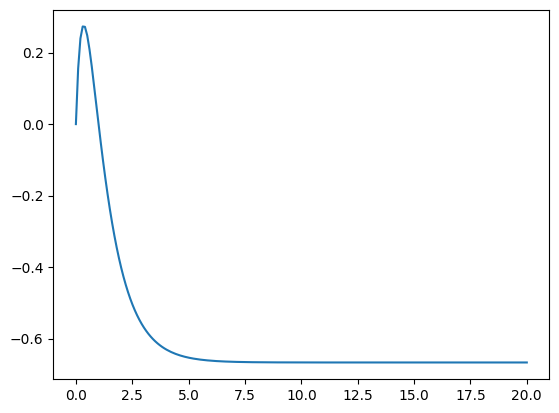

In [29]:
def evaluateBranching(multiplier:float, zero:float, pole1:float, pole2:float,
                          times=TIMES,
        is_plot:bool=True)->Tuple[control.TransferFunction, np.ndarray]:
    """
    Construct the transfer function, and simulate it.
    """
    tf = control.TransferFunction([multiplier, -multiplier*zero], [1, -pole1-pole2,
                pole1*pole2])
    _, yv = control.step_response(tf, T=times)
    plt.plot(times, yv)
    if not is_plot:
        plt.close()
    return tf, yv

# TESTS
results = evaluateBranching(2, 1, -1, -3, is_plot=True)
assert(isinstance(results[0], control.TransferFunction))
assert(len(results[1]) == len(TIMES))
print("OK!")

## Summary

* One step sequential: $\frac{m}{s - p}$
* Two step sequential: $\frac{m^{\prime} }{(s - p_1)(s - p_2)}$
* Branching: $\frac{m (s + z)}{(s - p_1)(s - p_2)}$

# Helpers

In [16]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax

    def __repr__(self):
        return ""

In [17]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Comparing Network Structures

**Research questions**
1. When do two different network structures have the same behavior?
2. What they have different behaviors, what are they?

## One Step vs.Two Step

1. What are we comparing between the networks? DC Gain? Settling time?
1. How will we compare these two networks? That is, what are the factors that will vary.

Hypothesis: We can make 2-step look like 1-step by:
* $p_1$ is very negative. Say, $p_1 = -100$
* $p_2 = p$
* $m^{\prime} = p_1 m$

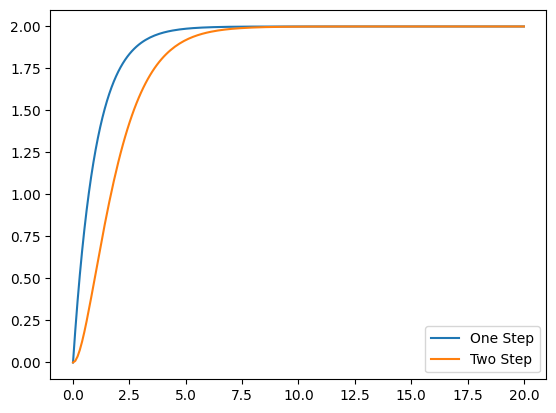

In [37]:
def compare(onestep_m:float, onestep_p:float, times=TIMES):
    """
    Calculate twostep_m, twostep_p1, twostep_p2 that give the same
    step response as onestep.
    """
    _, onestep_y = evaluateOneSequential(onestep_m, onestep_p, times=TIMES,
                                         is_plot=False)
    # Calculate parameters of two step system
    twostep_p1 = -100
    twostep_p1 = onestep_p
    twostep_p2 = onestep_p
    twostep_m = -onestep_m * twostep_p1
    # Get the two step response
    _, twostep_y = evaluateTwoSequential(twostep_m, twostep_p1, twostep_p2,
            times=TIMES, is_plot=False)
    # Plot
    plt.plot(times, onestep_y, label="One Step")
    plt.plot(times, twostep_y, label="Two Step")
    plt.legend()
    plt.show()

# Test
compare(2, -1)

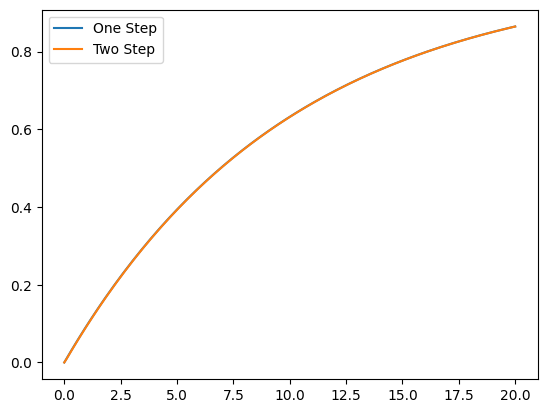

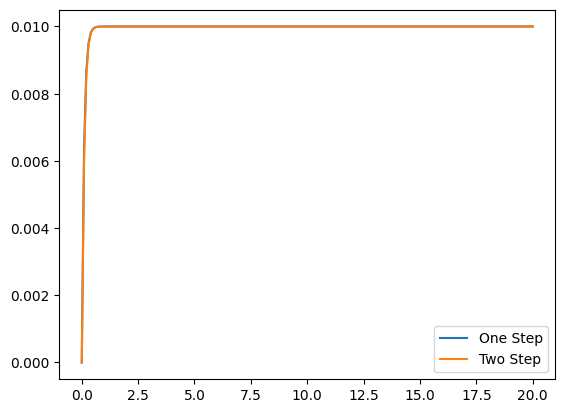

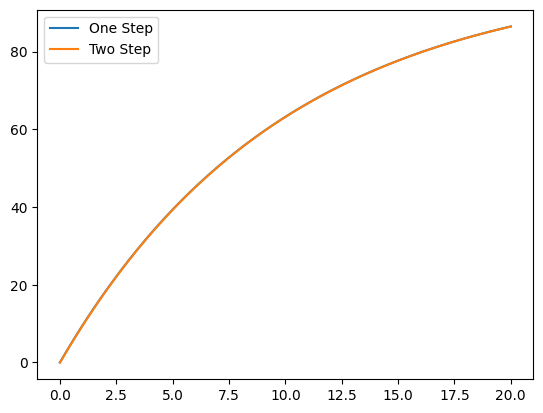

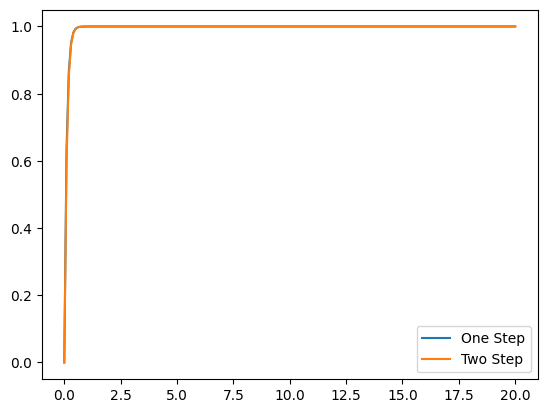

In [36]:
for m in [.1, 10]:
    for p in [-.1, -10]:
        compare(m, p)

## One Step vs. Branching

## Two Step vs. Branching